## Distogram

In [ ]:
!pip install biopython

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, NeighborSearch, PDBList
from Bio.PDB.Polypeptide import is_aa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/flamingo-pep-gen')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, is_aa
import os
import glob

parent_dir = 'pinder-dataset/2023-11/pdbs/2023-11/pdbs/'
pdb_files = glob.glob(os.path.join(parent_dir, '*.pdb'))
# pdb_files = glob.glob('pinder-dataset/2023-11/pdbs/2023-11/pdbs/*')


In [ ]:
len(pdb_files)

In [ ]:
# pdb_files = [f for f in os.listdir(parent_dir) if os.path.isfile(os.path.join(parent_dir, f))]

In [ ]:
len(pdb_files)

In [ ]:
save_path = '/content/drive/MyDrive/flamingo-pep-gen/pinder-dataset/2023-11/distograms-10A/'

In [ ]:
# os.mkdir('/content/drive/MyDrive/flamingo-pep-gen/pinder-dataset/2023-11/distograms-10A/')

In [ ]:

# Counter for processed files
processed_files_count = 0

def process_pdb_file(pdb_file_path, save_path):
    global processed_files_count

    pdb_id = pdb_file_path.split('/')[-1].split('.')[0]  # Extract pdb_id from file path

    # Check if the files have already been processed
    matrix_file = os.path.join(save_path, pdb_id + "_matrix.npy")
    distogram_image_file = os.path.join(save_path, pdb_id + "_distogram.png")
    contact_map_image_file = os.path.join(save_path, pdb_id + "_contact_map.png")

    if os.path.exists(matrix_file) and os.path.exists(distogram_image_file) and os.path.exists(contact_map_image_file):
        print(f"Skipping already processed file: {pdb_file_path}")
        print('processing_files_count:',processed_files_count)
        processed_files_count += 1
        return

    print(f"Processing PDB file at {pdb_file_path}")

    # Dictionary to store residue information
    residue_info = {}
    distance_results = {}

    # Load the PDB file using a PDBParser
    pdb_parser = PDBParser(QUIET=True)
    pdb_id = pdb_file_path.split('/')[-1].split('.')[0]  # Extract pdb_id from file path
    structure = pdb_parser.get_structure(pdb_id, pdb_file_path)

    # Process each chain and residue in the PDB file
    for chain in structure.get_chains():
        chain_id = chain.get_id()
        for residue in chain:
            if is_aa(residue, standard=True):
                residue_id = residue.get_id()[1]
                residue_key = (chain_id, residue_id)
                if "CA" in residue:
                    residue_info[residue_key] = {
                        "coordinates": residue["CA"].get_coord()
                    }

    # Calculate distances between residues
    for residue_key1, info1 in residue_info.items():
        for residue_key2, info2 in residue_info.items():
            if residue_key1 != residue_key2:
                distance = np.linalg.norm(info1["coordinates"] - info2["coordinates"])
                chain_dist = "Different chains" if residue_key1[0] != residue_key2[0] else "Same chain"
                distance_results[(residue_key1, residue_key2)] = (distance, chain_dist)

    # Interaction calculation and plotting
    # Initialize distance matrix and chain boundaries for plotting
    num_residues = len(residue_info)
    dist_matrix = np.zeros((num_residues, num_residues))
    chain_boundaries = []
    prev_chain = None
    for i, (residue_key1, info1) in enumerate(residue_info.items()):
        if prev_chain != residue_key1[0]:
            if prev_chain is not None:
                chain_boundaries.append(i)
            prev_chain = residue_key1[0]
        for j, (residue_key2, info2) in enumerate(residue_info.items()):
            if residue_key1 != residue_key2:
                dist_matrix[i, j] = distance_results[(residue_key1, residue_key2)][0]

    # Save the distogram matrix
    matrix_filename = os.path.join(save_path, pdb_id + "_matrix.npy")
    np.save(matrix_filename, dist_matrix)

    # Plot and save the distogram
    plt.imshow(dist_matrix, cmap="viridis", origin="lower", extent=[0, num_residues, 0, num_residues])
    plt.colorbar(label="Distance (Å)")
    plt.title(f"Residue-Residue Distogram for {pdb_id}")
    distogram_image_path = os.path.join(save_path, pdb_id + "_distogram.png")
    plt.savefig(distogram_image_path)
    plt.close()

    # Plot and save the binary contact map
    interaction_distance_threshold = 10
    plt.imshow((dist_matrix < interaction_distance_threshold), cmap="viridis", origin="lower", extent=[0, num_residues, 0, num_residues])
    plt.title(f"Residue-Residue Binary Contact Map for {pdb_id}")
    contact_map_image_path = os.path.join(save_path, pdb_id + "_contact_map.png")
    plt.savefig(contact_map_image_path)
    plt.close()

    print('processing_files_count:',processed_files_count)
    processed_files_count += 1


In [ ]:

# Loop through the PDB files and process each one
for pdb_file_path in pdb_files:
    process_pdb_file(pdb_file_path, save_path)


## concatenated ESM-2

In [5]:
import os
import pandas as pd

# Define the paths
metadata_path = '/content/metadata.csv'
distogram_dir = '/content/drive/MyDrive/distograms-10A'

# Load the metadata CSV
metadata = pd.read_csv(metadata_path)

# Extract IDs from metadata
metadata_ids = set(metadata['id'].tolist())


In [12]:
len(metadata_ids)

239098

In [13]:
# List files in the distogram directory and extract PDB IDs
distogram_files = os.listdir(distogram_dir)
distogram_ids = {file.split('_distogram.png')[0] for file in distogram_files if '--' in file}

# Check for intersection
intersecting_ids = metadata_ids.intersection(distogram_ids)

# Output the result
print(f"Number of matching IDs: {len(intersecting_ids)}")
print("Matching IDs:", intersecting_ids)


Number of matching IDs: 4697
Matching IDs: {'6kpa__F1_Q97YJ9--6kpa__G1_Q97YJ9', '4fmg__C1_C0JPK1--4fmg__D1_C0JPK1', '7yy4__B2_B1MDL6--7yy4__C2_B1MDL6', '4lg2__A1_Q8JPY0--4lg2__B1_Q8JPY0', '4jk1__C1_P0A8V2--4jk1__F1_P00579', '6ck7__A1_Q5ZSC4--6ck7__B1_Q5ZSC4', '7p5x__C1_P60281--7p5x__E1_A0QWT1', '6j5a__B1_A0A287B4I0--6j5a__D1_Q95339', '3h87__C2_O07227--3h87__D2_O07227', '4p18__G1_P07798--4p18__W1_P07798', '3u8q__A1_P24627--3u8q__B1_P24627', '4p72__A1_Q9I0A4--4p72__C1_Q9I0A3', '5bse__B1_G7KRM5--5bse__D1_G7KRM5', '6phe__D1_A0A077EEZ5--6phe__F1_A0A077EEZ5', '6rb9__A1_Q02307--6rb9__B1_Q02307', '7yu8__B1_P63096--7yu8__C1_P54311', '2jdm__B1_Q9HYN5--2jdm__C1_Q9HYN5', '1z88__A1_Q540U1--1z88__B1_Q540U1', '1ezv__D2_P07143--1ezv__I2_P22289', '3hi4__A1_P22862--3hi4__B1_P22862', '2ooz__A1_P14174--2ooz__B1_P14174', '3ju9__A2_P55915--3ju9__A4_P55915', '7ylv__C1_P39076--7ylv__D1_P39076', '3rk3__A1_P63027--3rk3__B1_P32851', '2qin__B1_P52700--2qin__D1_P52700', '2ag0__A1_Q9F4L3--2ag0__B1_Q9F4L3', '6x2m__B

In [14]:
intersecting_ids_df = pd.DataFrame(list(intersecting_ids), columns=['id'])
output_csv_path = '/content/intersecting_ids.csv'  # Define path for the output CSV

# Save the DataFrame to a CSV file
intersecting_ids_df.to_csv(output_csv_path, index=False)

print(f"Intersecting IDs saved to {output_csv_path}")

Intersecting IDs saved to /content/intersecting_ids.csv


In [ ]:
distogram_ids

In [15]:
!pip install fair-esm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.5 MB/s eta 0:00:00


In [16]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from transformers import T5ForConditionalGeneration, T5Tokenizer
import esm
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

# Load ESM-2 model for embeddings
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
esm_model.eval()
if torch.cuda.is_available():
    esm_model.cuda()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [17]:
import torch
from torch.utils.data import Dataset
import esm

class ProteinPairsDataset(Dataset):
    def __init__(self, fasta_file):
        self.sequence_data = {}
        self.load_sequences(fasta_file)

    def load_sequences(self, fasta_file):
        current_header = ""
        with open(fasta_file, 'r') as f:
            for line in f:
                if line.startswith('>'):
                    current_header = line[1:].strip()
                else:
                    seq1, seq2 = line.strip().split(',')
                    self.sequence_data[current_header] = (seq1, seq2)

    def __len__(self):
        return len(self.sequence_data)

    def __getitem__(self, idx):
        header = list(self.sequence_data.keys())[idx]
        seq1, seq2 = self.sequence_data[header]
        emb1 = self.generate_esm_embedding(seq1)
        emb2 = self.generate_esm_embedding(seq2)
        concatenated_embedding = torch.cat((emb1, emb2), dim=0)
        return {header: concatenated_embedding}

    def generate_esm_embedding(self, seq):
        batch_labels, batch_strs, batch_tokens = batch_converter([("", seq)])
        batch_tokens = batch_tokens.to('cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            results = esm_model(batch_tokens, repr_layers=[33])
        token_representations = results["representations"][33]
        seq_len = (batch_tokens != alphabet.padding_idx).sum(1).item()
        return token_representations[0, 1:seq_len-1].cpu()


In [18]:

# Usage example
fasta_file = '/content/sequences_esm-26.fasta'
dataset = ProteinPairsDataset(fasta_file)

# Accessing the first item in the dataset
first_item = dataset[0]
print(first_item)


{'6kpa__F1_Q97YJ9--6kpa__G1_Q97YJ9': tensor([[ 0.3139, -0.0509, -0.1930,  ...,  0.0281, -0.1715, -0.0755],
        [ 0.1223, -0.0933, -0.3406,  ..., -0.0361,  0.0551, -0.1054],
        [-0.1298,  0.0771, -0.1424,  ...,  0.0712,  0.0447, -0.1218],
        ...,
        [ 0.1815, -0.1354, -0.0028,  ..., -0.1126,  0.0451, -0.1150],
        [ 0.1240, -0.1464, -0.0027,  ..., -0.0037,  0.0707, -0.0379],
        [ 0.0795, -0.0415, -0.2137,  ..., -0.1478, -0.1127,  0.0556]])}


In [25]:
print(len(dataset))
print(dataset[0]['6kpa__F1_Q97YJ9--6kpa__G1_Q97YJ9'].shape)

4697
torch.Size([656, 1280])


In [26]:
# Process the dataset to store embeddings
processed_data = {}
for idx in tqdm(range(len(dataset))):
    processed_data.update(dataset[idx])

100%|██████████| 4697/4697 [21:48<00:00,  3.59it/s]


In [31]:
import pickle
with open('protein_pairs_dataset.pkl', 'wb') as file:
    pickle.dump(processed_data, file)

# esm-2 distogram predictor

In [32]:
!pip install biopython biotite
!pip install git+https://github.com/facebookresearch/esm.git
!apt-get install aria2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 MB 30.4 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-wgu6a2dz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-wgu6a2dz
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.1-py3-none-any.whl size=105381 sha256=6c3f1b872cd611532314fbb224ffff34a091412babfbad786dcb0a91b4d979de
  Stored in directory: /tmp/pip-ephem-wheel-cache-lw9rgcr9/wheels/f3/b2/ec/4db0b108f6367c7563f99b2445e1137d486003fb2f9bfd2f53
Successfully built fair-esm
  Attempting uninstall: fair-esm
    Found existing installation: fair-esm 2.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.2 [45.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 2s (798 kB/s)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.2_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu

In [34]:
!mkdir -p /root/.cache/torch/hub/checkpoints
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50S-contact-regression.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/models/esm_msa1b_t12_100M_UR50S.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/regression/esm_msa1b_t12_100M_UR50S-contact-regression.pt


12/27 03:29:50 [NOTICE] Downloading 1 item(s)

12/27 03:29:50 [ERROR] CUID#7 - Download aborted. URI=https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt
Exception: [AbstractCommand.cc:351] errorCode=22 URI=https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt
  -> [HttpSkipResponseCommand.cc:239] errorCode=22 The response status is not successful. status=403

12/27 03:29:50 [NOTICE] Download GID#fede02df0f9c7f8b not complete: 

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
fede02|ERR |       0B/s|https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt

Status Legend:
(ERR):error occurred.

aria2 will resume download if the transfer is restarted.
If there are any errors, then see the log file. See '-l' option in help/man page for details.

12/27 03:29:50 [NOTICE] Downloading 1 item(s)

12/27 03:29:51 [ERROR] CUID#7 - Download aborted. URI=https://dl.fbaip

## Define Functions

In [38]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd

import esm

torch.set_grad_enabled(False)

### Parsing alignments

In [39]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

### Converting structures to contacts

There are many ways to define a protein contact. Here we're using the definition of 8 angstroms between carbon beta atoms. Note that the position of the carbon beta is imputed from the position of the N, CA, and C atoms for each residue.

In [40]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))

    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

### Subsampling MSA

In [41]:
# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa

    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

### Compute contact precisions

In [42]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

### Plotting Results

In [43]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

## Predict and Visualize

### Read Data

In [ ]:
# This is where the data is actually read in
PDB_IDS = ["1a3a", "5ahw", "1xcr"]

structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name, "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain="A")
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"data/{name.lower()}_1_A.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

### ESM-2 Predictions

In [ ]:
esm2, esm2_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm2 = esm2.eval().cuda()
esm2_batch_converter = esm2_alphabet.get_batch_converter()

In [ ]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,ESM-2 (Unsupervised),0.801181,0.662069,0.805556,0.896552,0.528245,0.296552,0.500000,0.827586,0.612222,0.344828,0.569444,0.931035,0.806507,0.689655,0.791667,0.931035
1,5ahw,ESM-2 (Unsupervised),0.819763,0.680000,0.838710,0.960000,0.543314,0.296000,0.500000,0.840000,0.569258,0.304000,0.548387,0.920000,0.937361,0.864000,0.951613,0.960000
2,1xcr,ESM-2 (Unsupervised),0.529522,0.351438,0.500000,0.693548,0.344734,0.204473,0.320513,0.516129,0.410161,0.265176,0.365385,0.596774,0.576668,0.408946,0.544872,0.758065


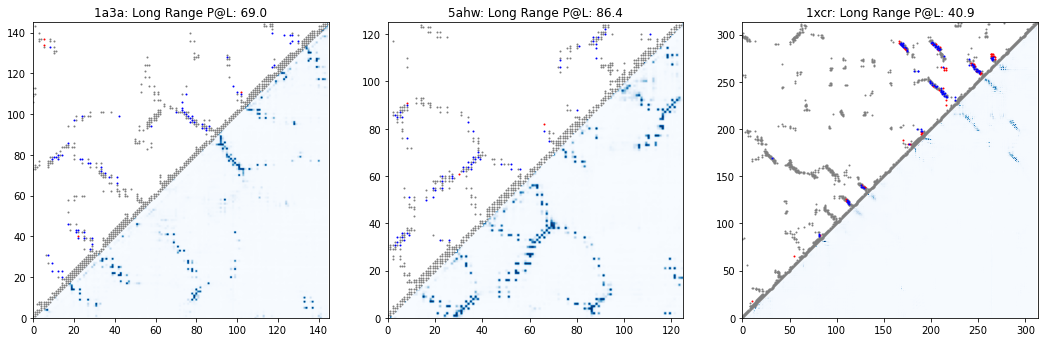

In [ ]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

### MSA Transformer Predictions

In [ ]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [ ]:
msa_transformer_predictions = {}
msa_transformer_results = []
for name, inputs in msas.items():
    inputs = greedy_select(inputs, num_seqs=128) # can change this to pass more/fewer sequences
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(msa_transformer_predictions[name], contacts[name]))
    msa_transformer_results.append(metrics)
msa_transformer_results = pd.DataFrame(msa_transformer_results)
display(msa_transformer_results)

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,MSA Transformer (Unsupervised),0.853126,0.765517,0.875000,0.827586,0.575057,0.317241,0.569444,0.862069,0.601065,0.337931,0.597222,0.827586,0.837919,0.724138,0.861111,0.896552
1,5ahw,MSA Transformer (Unsupervised),0.850377,0.736000,0.854839,0.920000,0.547282,0.288000,0.548387,0.880000,0.581426,0.320000,0.548387,0.880000,0.967116,0.896000,0.967742,1.000000
2,1xcr,MSA Transformer (Unsupervised),0.675652,0.469649,0.679487,0.870968,0.470373,0.249201,0.442308,0.709677,0.508027,0.316294,0.487179,0.677419,0.878467,0.769968,0.891026,0.967742


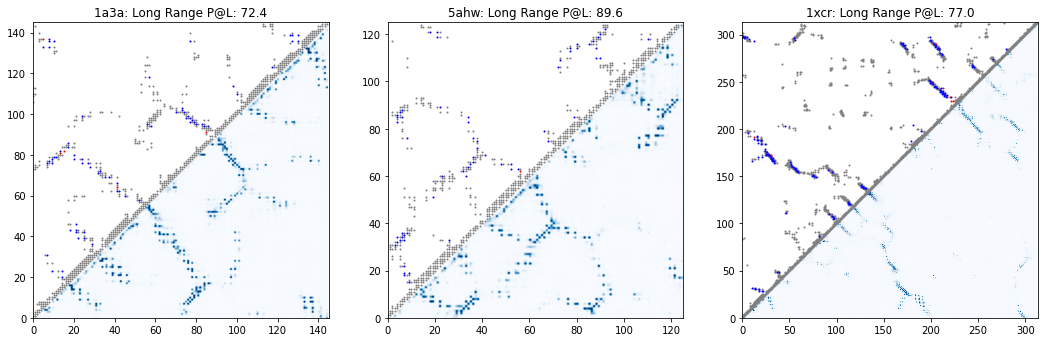

In [ ]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = msa_transformer_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()